# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA

In [130]:
# Separating this from the rest of the rest of the imports
# I need to continously add functions and this way I don't keep reimporting other libraries
%run -i 'functions2.py'

In [126]:
df = pd.read_csv('zillow_data.csv')

In [65]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [66]:
df.shape

(14723, 272)

In [67]:
# I need to look through these regions and see what I can pull out
# There are 14723 individual zipcodes
# How many unique cities are there? Metros? Counties?
print('There are', len(set(df['City'])),'cities')
print('There are', len(set(df['Metro'])), 'metros')
print('There are', len(set(df['CountyName'])), 'counties')

There are 7554 cities
There are 702 metros
There are 1212 counties


The data that will be selected will come from the top emerging tech cities in the United States based on an article online (see README).

In [68]:
us_map = folium.Map(location = [37.0902, -95.7129], tiles='Stamen Terrain', zoom_start=4)
us_map

Save mapping for later.  

In [69]:
# Top emerging tech cities
cities = ['Austin', 'Raleigh','Atlanta','Phoenix','Miami','Huntsville','Baltimore']

In [70]:
# In order to get Washington DC I needed to change the City value to Washington DC
# I also need to change the Metro to Washington DC because there is another Metro = Washington
df['City'][df.CountyName == 'District of Columbia'] = 'Washington DC'
df['Metro'][df.CountyName == 'District of Columbia'] = 'Washington DC'

functions2.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop nulls permanently, and reset the index."""
functions2.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [71]:
# Checking work
df[df['CountyName']=='District of Columbia'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
29,66126,20002,Washington DC,DC,Washington DC,District of Columbia,30,94300.0,94000.0,93700.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
33,66133,20009,Washington DC,DC,Washington DC,District of Columbia,34,178800.0,179200.0,179600.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200
181,66135,20011,Washington DC,DC,Washington DC,District of Columbia,182,118900.0,118500.0,118200.0,...,582200,586200,591200,593200,591200,589500,590800,599100,611400,619100
246,66142,20019,Washington DC,DC,Washington DC,District of Columbia,247,91300.0,91000.0,90600.0,...,291100,296300,302500,306700,308800,310800,313400,314100,311800,308600
258,66125,20001,Washington DC,DC,Washington DC,District of Columbia,259,92000.0,92600.0,93200.0,...,765000,768800,771200,773300,777600,780500,781600,785500,791400,793300


In [72]:
# Now going to make a dataframe containing only those in this list
selected = df[df['City'].isin(cities)]

It is clear that there are duplicate names in the City column. That is, some states have cities with the same name. 

In [73]:
# I used this cell to look at each city in my list and view how many other states
# Have a city with the same name, and took note of it on paper
# Change the city name in the conditional to get the value
selected[selected['City'] == 'Baltimore']['State'].value_counts()

MD    14
OH     1
Name: State, dtype: int64

In [74]:
# Found that if the value_counts is less than 4, the city is not in the targeted state
selected.sort_values(['City','State'])

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
1097,71029,30309,Atlanta,GA,Atlanta,Fulton,1098,260400.0,261700.0,262900.0,...,780200,785900,797400,807600,813500,819200,824900,834500,850300,860700
1223,71043,30324,Atlanta,GA,Atlanta,Fulton,1224,189400.0,190800.0,192300.0,...,506500,509600,515100,519600,523900,528500,532600,537900,543700,545700
1758,71036,30316,Atlanta,GA,Atlanta,Fulton,1759,62300.0,62300.0,62300.0,...,240900,244200,247900,251700,255300,258800,261600,264300,268700,272500
1787,71025,30305,Atlanta,GA,Atlanta,Fulton,1788,297200.0,299000.0,300900.0,...,860000,863400,868200,871200,872400,876800,885600,892900,897600,898200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,69457,27617,Raleigh,NC,Raleigh,Wake,4561,167900.0,166500.0,165100.0,...,282200,283200,284700,285900,286700,287900,289400,290900,292300,293100
4719,69447,27607,Raleigh,NC,Raleigh,Wake,4720,162800.0,163400.0,164000.0,...,387600,389500,391500,394500,397800,400700,401900,403100,405100,406400
7598,69448,27608,Raleigh,NC,Raleigh,Wake,7599,153200.0,154600.0,156100.0,...,535300,537600,542200,544200,544900,546700,549600,553100,559200,564900
7981,69441,27601,Raleigh,NC,Raleigh,Wake,7982,110000.0,109800.0,109500.0,...,243800,249800,253900,259000,267500,274800,278800,282200,284500,284700


In [75]:
# After noting the value counts for cities in the Metro areas
# I found out that if the value counts is greater than 4
# The city was from the right state
# This takes care of those duplicate city names
selected = selected.groupby('Metro').filter(lambda x: len(x)>4)

In [76]:
selected['Metro'].value_counts()

Austin                   39
Phoenix                  35
Raleigh                  15
Baltimore                15
Atlanta                  12
Huntsville               10
Miami-Fort Lauderdale     9
Name: Metro, dtype: int64

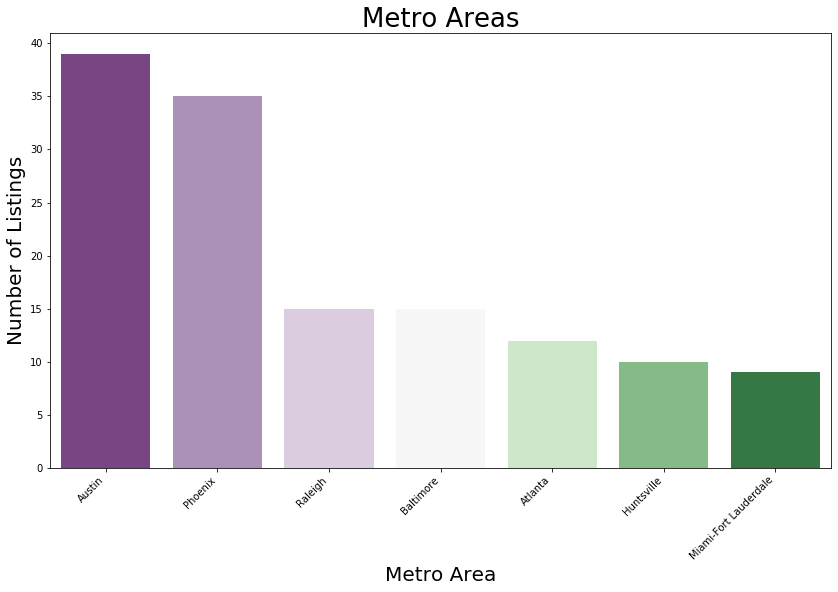

In [77]:
make_value_chart(selected, 'Metro', 'Metro Area', 'Number of Listings', 'Metro Areas')

Doing this research based on the Metro area seems like a better idea because within a metro area could be a variety of towns, changing the overall outcome of the analysis.

In [78]:
# Going to make a list of the top 20 metro areas
metros = list(selected['Metro'].unique())
metros

['Phoenix',
 'Austin',
 'Raleigh',
 'Atlanta',
 'Baltimore',
 'Miami-Fort Lauderdale',
 'Huntsville']

Now I can use the `metros` list to filter my original dataframe.  
Going to just re-use the `selected` name

In [79]:
selected = df[df['Metro'].isin(metros)]

In [80]:
selected

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,138400.0,...,235000,235900,236600,237400,238500,239400,240000,241000,242200,242800
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
32,92551,78613,Cedar Park,TX,Austin,Williamson,33,169600.0,169000.0,168600.0,...,291400,291700,292700,294400,295800,296200,295900,296400,297500,297300
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14048,82500,55936,Grand Meadow,MN,Austin,Mower,14049,76200.0,76800.0,77400.0,...,105700,105700,106000,106600,109400,112700,114000,114600,116700,119000
14159,66966,21668,Sudlersville,MD,Baltimore,Queen Annes,14160,96500.0,96600.0,96700.0,...,214600,211100,208600,208000,207600,207300,207800,209300,210800,211100
14230,82512,55951,Le Roy,MN,Austin,Mower,14231,53900.0,54000.0,54300.0,...,79100,79600,80300,80700,82100,83900,84200,84800,86800,88800
14464,66627,20779,Tracys Landing,MD,Baltimore,Anne Arundel,14465,177000.0,176500.0,175900.0,...,388100,390000,393400,398900,403900,407300,412900,417100,418600,418900


In [81]:
# Good to go
selected['State'].value_counts()

FL    162
GA    152
AZ    126
MD    122
TX     77
NC     43
AL     20
MN      3
Name: State, dtype: int64

The decision was made to choose from a list of emerging tech areas. I included a couple that were from the list of top tech cities, just to include some diversity. 

In [82]:
# coordinates for the general area of these metros
# baltimore, detroit, austin, miami, atlanta, phoenix, huntsville, raleigh
lats = [39.284707, 42.3314, 30.326374, 25.558428, 33.844371, 33.276539, 34.654126, 35.851463]
longs = [-76.620489, -83.0458, -97.771258, -80.458168, -84.47405, -112.18717, -86.73987, -78.63141]
coords = [[39.284707,-76.620489],[42.3314,-83.0458],[30.326374,-97.771258],[25.558428,-80.458168],
          [33.844371,-84.47405], [33.276539,-112.18717], [34.654126,-86.73987], [35.851463,-78.63141]
         ]

In [83]:
makeMarker(coords, us_map)

In [84]:
us_map

In [85]:
selected.sort_values(by='State')

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
713,73596,35758,Madison,AL,Huntsville,Madison,714,NaN,NaN,NaN,...,212000,211700,212500,214100,215300,216100,217700,221000,224700,227500
3541,73540,35611,Athens,AL,Huntsville,Limestone,3542,50200.0,50700.0,51300.0,...,96300,96100,95900,95500,95600,95700,95700,95800,95900,95700
9344,73543,35614,Athens,AL,Huntsville,Limestone,9345,54600.0,55000.0,55500.0,...,99200,98000,97000,96400,96500,96400,96100,96200,96500,96400
4720,73588,35749,Harvest,AL,Huntsville,Madison,4721,NaN,NaN,NaN,...,159200,159300,159700,159200,158600,159600,161000,163600,167700,170200
5465,73542,35613,Athens,AL,Huntsville,Limestone,5466,97600.0,98300.0,99000.0,...,170500,171000,171300,171700,172400,172600,172900,173600,174000,173700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3575,92541,78602,Bastrop,TX,Austin,Bastrop,3576,74400.0,74700.0,75100.0,...,185800,189600,193100,194100,192600,191700,191400,192000,194700,197500
3581,92655,78746,Austin,TX,Austin,Travis,3582,493300.0,496600.0,500100.0,...,910500,900700,895800,900200,905500,909000,912600,917200,921200,918700
3629,92570,78634,Hutto,TX,Austin,Williamson,3630,133200.0,132800.0,132400.0,...,210900,211800,212900,215000,217600,218800,219200,220700,222200,222500
3035,92618,78705,Austin,TX,Austin,Travis,3036,197500.0,199300.0,201000.0,...,486400,485000,483200,481900,481900,483200,484300,489100,501200,511600


Will need to deal with the null values. Most likely going to use the mean of the Metro to fill in the null values.  
Need to do more research on how the melting function works. I think it averages all of the cities in the dataframe that you provide it. If that is the case I will need to dig a bit on that.

In [86]:
selected.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
18,92593,78660,Pflugerville,TX,Austin,Travis,19,138900.0,138600.0,138400.0,...,235000,235900,236600,237400,238500,239400,240000,241000,242200,242800
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
32,92551,78613,Cedar Park,TX,Austin,Williamson,33,169600.0,169000.0,168600.0,...,291400,291700,292700,294400,295800,296200,295900,296400,297500,297300
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800


Certain columns can be dropped. RegionID, SizeRank. RegionName can be changed to zipcode. Would also like to make all of the columns lowercase.

In [87]:
selected.columns=selected.columns.str.lower()

In [88]:
selected = drop(selected, columns=['regionid', 'sizerank'])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [89]:
selected = rename_column(selected, 'regionname', 'zipcode')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
selected = rename_column(selected, 'countyname', 'county')

In [91]:
selected.head()

,zipcode,city,state,metro,county,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
18,78660,Pflugerville,TX,Austin,Travis,138900.0,138600.0,138400.0,138500.0,138700.0,...,235000,235900,236600,237400,238500,239400,240000,241000,242200,242800
28,30349,Riverdale,GA,Atlanta,Clayton,90900.0,91100.0,91200.0,91300.0,91300.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
32,78613,Cedar Park,TX,Austin,Williamson,169600.0,169000.0,168600.0,168500.0,168700.0,...,291400,291700,292700,294400,295800,296200,295900,296400,297500,297300
42,30044,Lawrenceville,GA,Atlanta,Gwinnett,111400.0,111800.0,112200.0,112500.0,112900.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,30043,Lawrenceville,GA,Atlanta,Gwinnett,135200.0,135500.0,135800.0,136000.0,136200.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800


In [92]:
selected['metro'].value_counts()

Miami-Fort Lauderdale    162
Atlanta                  152
Phoenix                  126
Baltimore                122
Austin                    76
Raleigh                   43
Huntsville                24
Name: metro, dtype: int64

In [93]:
# Now to separate all 7 metros into separate dataframes to prepare for melting
miami = selected[selected['metro'] == 'Miami-Fort Lauderdale']
atlanta = selected[selected['metro'] == 'Atlanta']
phoenix = selected[selected['metro'] == 'Phoenix']
baltimore = selected[selected['metro'] == 'Baltimore']
austin = selected[selected['metro'] == 'Austin']
raleigh = selected[selected['metro'] == 'Raleigh']
huntsville = selected[selected['metro'] == 'Huntsville']

In [94]:
print(huntsville['state'].value_counts())
print(austin['state'].value_counts())

AL    20
TX     4
Name: state, dtype: int64
TX    73
MN     3
Name: state, dtype: int64


In [95]:
# The remaining entries from other states with same metro names need to be removed
austin = austin[austin['state'] == 'TX']
huntsville = huntsville[huntsville['state'] == 'AL']

In [96]:
print(huntsville['state'].value_counts())
print(austin['state'].value_counts())

AL    20
Name: state, dtype: int64
TX    73
Name: state, dtype: int64


In [97]:
# Going to check for null values
austin.isnull().sum(axis=1)

18        0
32        0
66        0
77        0
98        0
         ..
10440     0
10970     0
12221     0
12831     0
12908    93
Length: 73, dtype: int64

In [98]:
# Need to see which columns have null values
print(miami.columns[miami.isna().any()].tolist())
atl = atlanta.columns[atlanta.isna().any()].tolist()
phx = phoenix.columns[phoenix.isna().any()].tolist()
blt = baltimore.columns[baltimore.isna().any()].tolist()
aus = austin.columns[austin.isna().any()].tolist()
print(raleigh.columns[raleigh.isna().any()].tolist())
hnt = huntsville.columns[huntsville.isna().any()].tolist()

[]
[]


There are clearly many columns in this data that are missing data for certain localities. I am going to try ot impute the mean for each of the columns.

In [99]:
# Going to make a copy of the original so if this doesn't work as intended it won't be trouble
atl_2 = atlanta.copy()
atl_2[atl]=atl_2[atl].fillna(atl_2.mean().iloc[0])

In [100]:
atlanta

,zipcode,city,state,metro,county,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,30349,Riverdale,GA,Atlanta,Clayton,90900.0,91100.0,91200.0,91300.0,91300.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,30044,Lawrenceville,GA,Atlanta,Gwinnett,111400.0,111800.0,112200.0,112500.0,112900.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,30043,Lawrenceville,GA,Atlanta,Gwinnett,135200.0,135500.0,135800.0,136000.0,136200.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,30096,Duluth,GA,Atlanta,Gwinnett,119700.0,120000.0,120300.0,120700.0,121000.0,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,30024,Suwanee,GA,Atlanta,Gwinnett,179600.0,181000.0,182400.0,183900.0,185200.0,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12956,30206,Concord,GA,Atlanta,Pike,NaN,NaN,NaN,NaN,NaN,...,145600,147000,148200,149000,149500,150200,150900,152000,153900,155600
13026,30256,Meansville,GA,Atlanta,Pike,NaN,NaN,NaN,NaN,NaN,...,142900,143500,143800,143900,144400,145200,146100,146600,147400,148300
13856,30234,Jenkinsburg,GA,Atlanta,Butts,60100.0,60800.0,61400.0,61900.0,62400.0,...,92100,92600,92900,93500,94000,94200,94500,94900,95500,95900
13918,30216,Flovilla,GA,Atlanta,Butts,50300.0,50900.0,51600.0,52200.0,52800.0,...,74100,75200,75500,75300,75100,75800,76300,77600,80400,82700


In [101]:
atl_2

,zipcode,city,state,metro,county,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,30349,Riverdale,GA,Atlanta,Clayton,90900.000000,91100.000000,91200.000000,91300.000000,91300.000000,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,30044,Lawrenceville,GA,Atlanta,Gwinnett,111400.000000,111800.000000,112200.000000,112500.000000,112900.000000,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,30043,Lawrenceville,GA,Atlanta,Gwinnett,135200.000000,135500.000000,135800.000000,136000.000000,136200.000000,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,30096,Duluth,GA,Atlanta,Gwinnett,119700.000000,120000.000000,120300.000000,120700.000000,121000.000000,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,30024,Suwanee,GA,Atlanta,Gwinnett,179600.000000,181000.000000,182400.000000,183900.000000,185200.000000,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12956,30206,Concord,GA,Atlanta,Pike,30202.052632,30202.052632,30202.052632,30202.052632,30202.052632,...,145600,147000,148200,149000,149500,150200,150900,152000,153900,155600
13026,30256,Meansville,GA,Atlanta,Pike,30202.052632,30202.052632,30202.052632,30202.052632,30202.052632,...,142900,143500,143800,143900,144400,145200,146100,146600,147400,148300
13856,30234,Jenkinsburg,GA,Atlanta,Butts,60100.000000,60800.000000,61400.000000,61900.000000,62400.000000,...,92100,92600,92900,93500,94000,94200,94500,94900,95500,95900
13918,30216,Flovilla,GA,Atlanta,Butts,50300.000000,50900.000000,51600.000000,52200.000000,52800.000000,...,74100,75200,75500,75300,75100,75800,76300,77600,80400,82700


That didn't work as intended. It seems to have filled the null values with the average of the entire data. All of the imputed values are the same :/  
Going to try something else.

In [102]:
# df.fillna(df.mean())
atl_3 = atlanta.copy()
atl_3.fillna(atl_3.mean())

,zipcode,city,state,metro,county,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,30349,Riverdale,GA,Atlanta,Clayton,90900.000000,91100.0,91200.000000,91300.0,91300.000000,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,30044,Lawrenceville,GA,Atlanta,Gwinnett,111400.000000,111800.0,112200.000000,112500.0,112900.000000,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,30043,Lawrenceville,GA,Atlanta,Gwinnett,135200.000000,135500.0,135800.000000,136000.0,136200.000000,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,30096,Duluth,GA,Atlanta,Gwinnett,119700.000000,120000.0,120300.000000,120700.0,121000.000000,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,30024,Suwanee,GA,Atlanta,Gwinnett,179600.000000,181000.0,182400.000000,183900.0,185200.000000,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12956,30206,Concord,GA,Atlanta,Pike,125410.769231,125930.0,126465.384615,127020.0,127585.384615,...,145600,147000,148200,149000,149500,150200,150900,152000,153900,155600
13026,30256,Meansville,GA,Atlanta,Pike,125410.769231,125930.0,126465.384615,127020.0,127585.384615,...,142900,143500,143800,143900,144400,145200,146100,146600,147400,148300
13856,30234,Jenkinsburg,GA,Atlanta,Butts,60100.000000,60800.0,61400.000000,61900.0,62400.000000,...,92100,92600,92900,93500,94000,94200,94500,94900,95500,95900
13918,30216,Flovilla,GA,Atlanta,Butts,50300.000000,50900.0,51600.000000,52200.0,52800.000000,...,74100,75200,75500,75300,75100,75800,76300,77600,80400,82700


That was easy. Going to apply this to all of my data frames with null values.

In [103]:
atlanta = atlanta.fillna(atlanta.mean())
phoenix = phoenix.fillna(phoenix.mean())
baltimore = baltimore.fillna(baltimore.mean())
austin = austin.fillna(austin.mean())
huntsville = huntsville.fillna(huntsville.mean())

In [104]:
# Going to print out lists of any columns with null values
# Should produce empty lists now
print(miami.columns[miami.isna().any()].tolist())
print(atlanta.columns[atlanta.isna().any()].tolist())
print(phoenix.columns[phoenix.isna().any()].tolist())
print(baltimore.columns[baltimore.isna().any()].tolist())
print(austin.columns[austin.isna().any()].tolist())
print(raleigh.columns[raleigh.isna().any()].tolist())
print(huntsville.columns[huntsville.isna().any()].tolist())

[]
[]
[]
[]
[]
[]
[]


Success. Now ready for further processing.

# Step 2: Data Preprocessing

In [105]:
# changed .values[1:] to .values[7:]
# did this as to not have to change the original df
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

# Step 3: EDA and Visualization

In [106]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [107]:
# Going to try out a combined function
# Time series index and melting
def melt_data(df):
    ''' 
    Takes a dataframe with datetime data that is in wide format and melts it into long format; 
    Tranforms data into datetime object with time as index.
    User will need to change columns names on first line of code according to their own dataframe.
    '''
    
    melted = pd.melt(df, id_vars=['zipcode', 'city', 'state', 'metro', 'county'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [108]:
# melting all dataframes
# I believe this function takes all values within the dataframe and averages them
miami = melt_data(miami)
atlanta = melt_data(atlanta)
phoenix = melt_data(phoenix)
baltimore = melt_data(baltimore)
austin = melt_data(austin)
raleigh = melt_data(raleigh)
huntsville = melt_data(huntsville)

<Figure size 432x288 with 0 Axes>

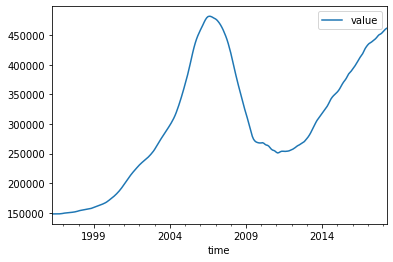

<Figure size 432x288 with 0 Axes>

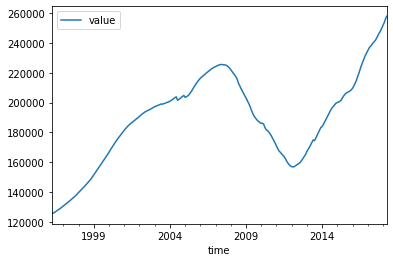

<Figure size 432x288 with 0 Axes>

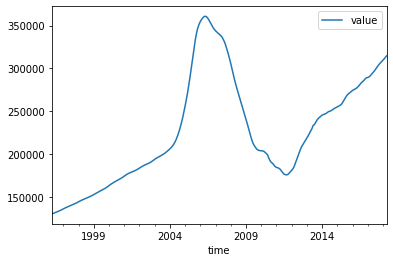

<Figure size 432x288 with 0 Axes>

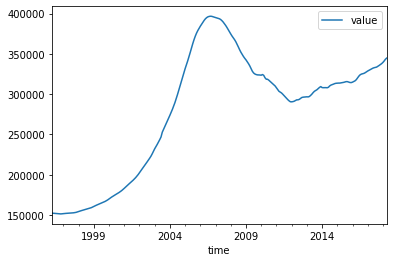

<Figure size 432x288 with 0 Axes>

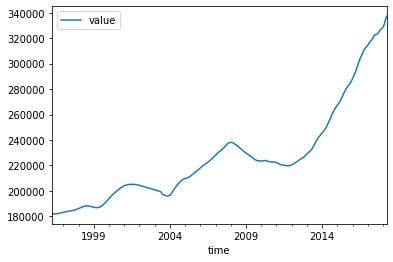

<Figure size 432x288 with 0 Axes>

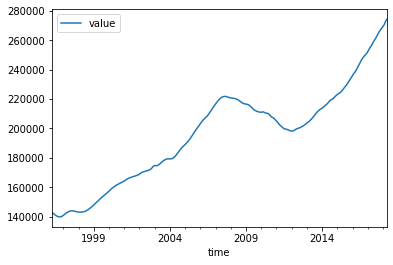

<Figure size 432x288 with 0 Axes>

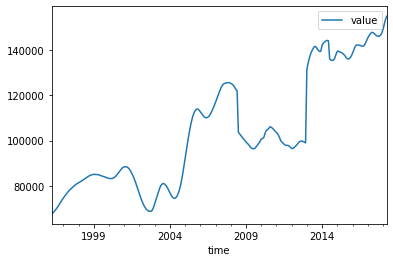

In [109]:
plt.figure()
miami.plot()
plt.figure()
atlanta.plot()
plt.figure()
phoenix.plot()
plt.figure()
baltimore.plot()
plt.figure()
austin.plot()
plt.figure()
raleigh.plot()
plt.figure()
huntsville.plot()

Time to check for stationarity via the Dickey Fuller Test and visualize the rolling average/stdev with the time series.

In [110]:
# Running miami first to test my function
dftest(miami)

Test Stat                -1.617015
P-Value                   0.474294
# Lags                   16.000000
# Observations          248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64

The p-value is much larger than the alpha of 0.05 - this time series is not stationary.

In [111]:
# Going to print the rest of the DF tests
print('Atlanta:\n',dftest(atlanta),'\n')
print('Phoenix:\n',dftest(phoenix),'\n')
print('Baltimore:\n', dftest(baltimore),'\n')
print('Austin:\n', dftest(austin),'\n')
print('Raleigh:\n', dftest(raleigh),'\n')
print('Huntsville\n', dftest(huntsville),'\n')

Atlanta:
 Test Stat                -1.458072
P-Value                   0.554141
# Lags                    7.000000
# Observations          257.000000
Critical Value (1%)      -3.456054
Critical Value (5%)      -2.872853
Critical Value (10%)     -2.572799
dtype: float64 

Phoenix:
 Test Stat                -1.894052
P-Value                   0.334864
# Lags                    5.000000
# Observations          259.000000
Critical Value (1%)      -3.455853
Critical Value (5%)      -2.872765
Critical Value (10%)     -2.572752
dtype: float64 

Baltimore:
 Test Stat                -2.055538
P-Value                   0.262764
# Lags                   12.000000
# Observations          252.000000
Critical Value (1%)      -3.456569
Critical Value (5%)      -2.873079
Critical Value (10%)     -2.572919
dtype: float64 

Austin:
 Test Stat                 0.932991
P-Value                   0.993506
# Lags                   16.000000
# Observations          248.000000
Critical Value (1%)      -3.45699

All of my series are not stationary. I cannot reject the null hypothesis (series is not stationary) because none of the p-values are less than my alpha of 0.05.  
Will need to look into differencing to remove trends. Before that, I would like to plot some of the other types of metrics like rolling average and stdev.. and make nicer looking plots.

Since the ARIMA model has differencing built in to the function, I won't waste time looking into different differencing patterns necessarily, but will look at a few just for reference and direction.  
The plan is as follows:
* ACF, PACF graphs for each data set
* Baseline ARIMA model
    * evaluate via RMSE, AIC, maybe one or two others
* Tune ARIMA models
    * evaluate as above
* Make forecasts for 12mo, 24mo, 36mo, and 48mo


Miami (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Atlanta (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Baltimore (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Austin (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Huntsville (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Raleigh (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 

Pheonix (<Figure size 1152x216 with 1 Axes>, <Figure size 1152x216 with 1 Axes>) 



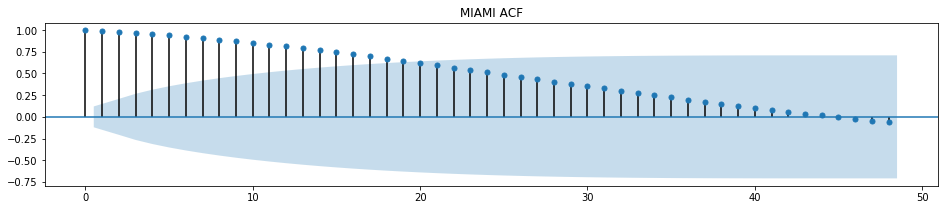

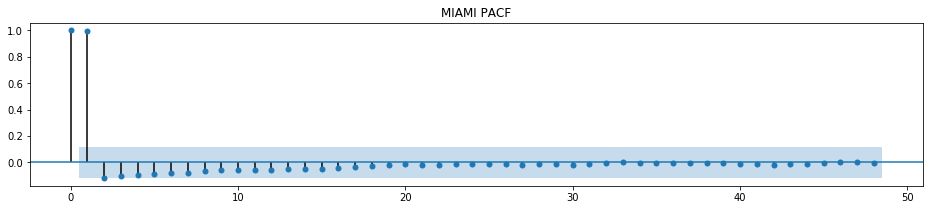

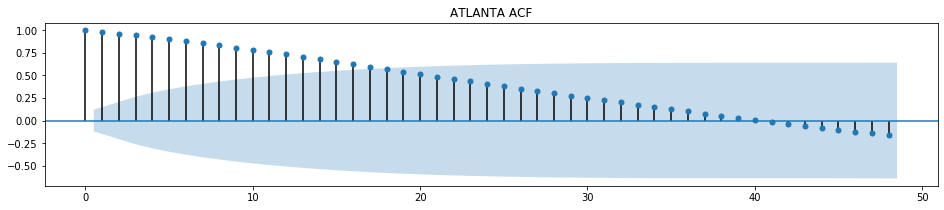

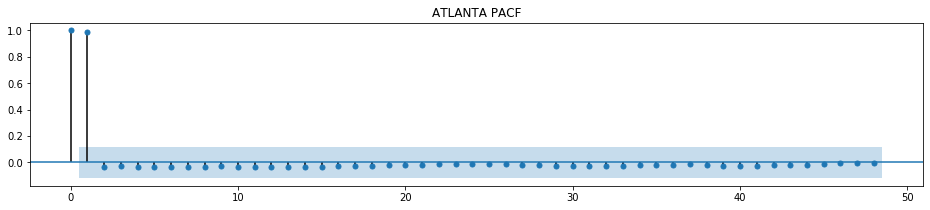

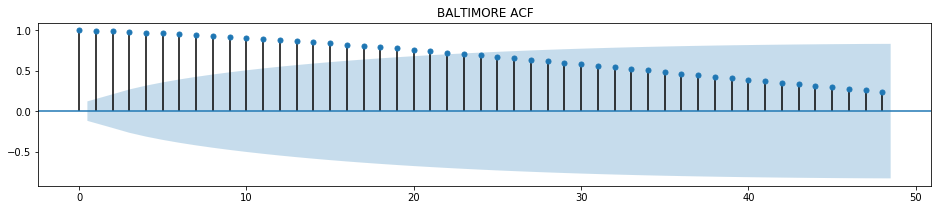

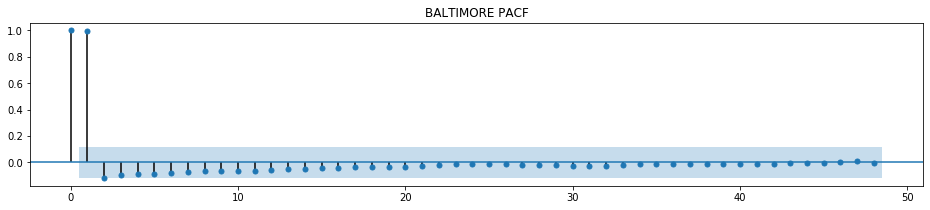

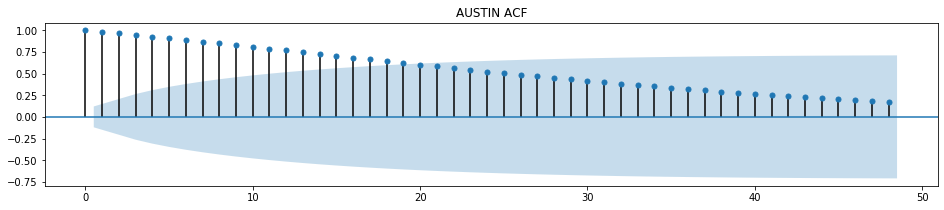

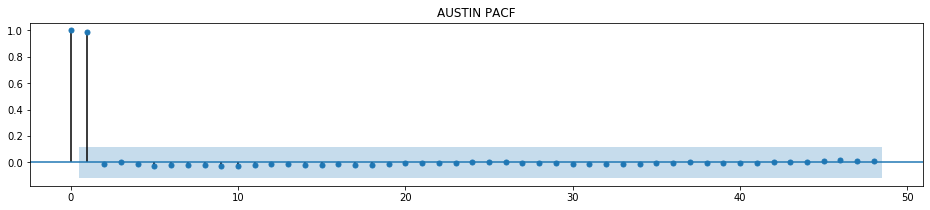

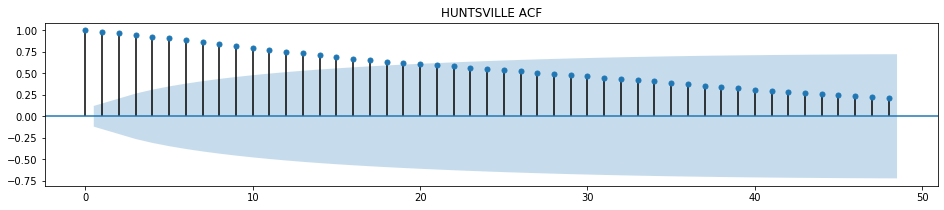

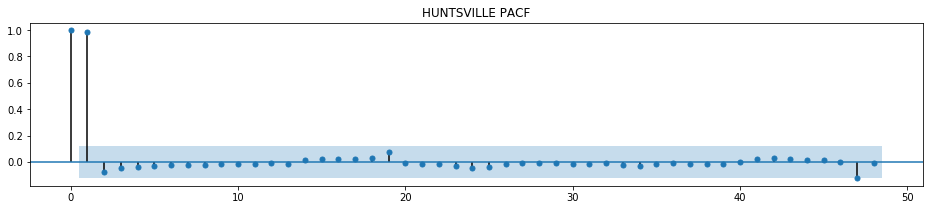

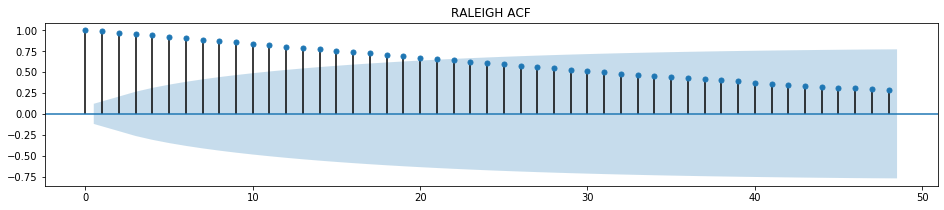

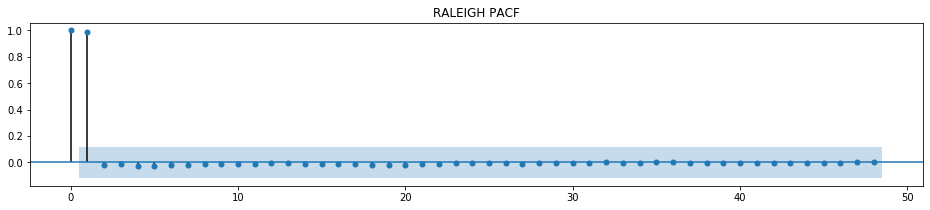

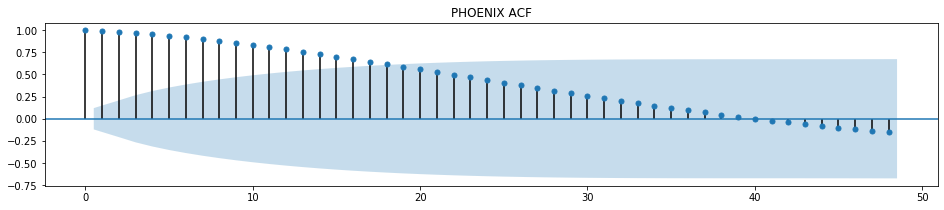

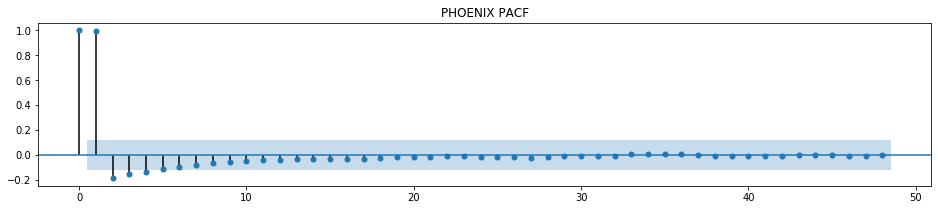

In [131]:
# Running the auto_corrs() function for each metro
print('Miami',auto_corrs(miami, 'MIAMI'),'\n')
print('Atlanta',auto_corrs(atlanta, 'ATLANTA'),'\n')
print('Baltimore',auto_corrs(baltimore, 'BALTIMORE'),'\n')
print('Austin',auto_corrs(austin, 'AUSTIN'),'\n')
print('Huntsville',auto_corrs(huntsville, 'HUNTSVILLE'),'\n')
print('Raleigh',auto_corrs(raleigh, 'RALEIGH'),'\n')
print('Pheonix',auto_corrs(phoenix, 'PHOENIX'),'\n')

In [133]:
arima = ARIMA()

TypeError: __new__() missing 2 required positional arguments: 'endog' and 'order'

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results